# Comparing the performance of old and new version of the code

This notebook presents the execution time and the mean squared error (MSE) between the actual latent function and the prediction of the two versions of the modulated GP code. The "old version" refers to the code shared by J. Hensman in the meeting last November 2016. The "new version" of the code has the following changes:

<ol>
  <li>__The atributes X, Y, Z of the ModGP class have been changed to Dataholders:__ This allows to feed the graph with new training data and inducing variables at every call of the .optimize() method in a foor loop without requiring to recompile the graph (useful to reduce time between loop executions when windowing input data).</li>
  <li>__The "whiten" option in the ModGP class has been activated:__ This corresponds to a linear transformation of the inducing variables. This contributes to a faster converenge even if the number of inducing variables increases. Therefore fewer iterations are needed, and a better approximation of the posterior is obtained (the more inducing variables the closer to the real posterior).</li>
  <li>__The method variational_expectations() of the class ModLik has been modified:__ A more efficient expression that only requires one dimensional quadratures was implemented. This produces a significant decrease of computation time in comparison with the former implementation.
</ol>  

The results shown below correspond to run the code over 1500 data samples. The number of iterations in the optimization procedure was 200. The same calculation was run 5 times in order to get an average idea of the excution time and MSE of both code versions. 

# Results using new code version

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import GPflow
import time
import modgp
import gpitch as gpi
from sklearn.metrics import mean_squared_error as mse

In [2]:
plt.rcParams['figure.figsize'] = (18, 6)  # set plot size

In [3]:
# generate synthetic data
fs = 16e3  # sample frequency
N = 1500  # number of samples
x = np.linspace(0, (N-1.)/fs, N).reshape(-1, 1)  # time vector
noise_var = 1.e-3
kenv = GPflow.kernels.Matern32(input_dim=1, lengthscales=0.01, variance=10.)
kper = GPflow.kernels.PeriodicKernel(input_dim=1, lengthscales=0.25,
                                     variance=np.sqrt(0.5), period=1./440)
Kenv = kenv.compute_K_symm(x)
Kper = kper.compute_K_symm(x)
np.random.seed(23)
f = np.random.multivariate_normal(np.zeros(x.shape[0]), Kper).reshape(-1, 1)
f /= np.max(np.abs(f))
g = np.random.multivariate_normal(np.zeros(x.shape[0]), Kenv).reshape(-1, 1)
mean = gpi.logistic(g)*f
y = mean + np.random.randn(*mean.shape) * np.sqrt(noise_var)

In [4]:
#ws = 500  # window size (samples), split data into windows, OR
ws = N  # use all data at once (i.e. no windowing)

Nw = N/ws  # number of windows
x_l = [x[i*ws:(i+1)*ws].copy() for i in range(0, Nw)]
y_l = [y[i*ws:(i+1)*ws].copy() for i in range(0, Nw)]

In [5]:
jump = 8  # initialize model
z = x_l[0][::jump].copy()
m = modgp.ModGP(x_l[0].copy(), y_l[0].copy(), kper, kenv, z, whiten=True)
m.likelihood.noise_var = noise_var
m.likelihood.noise_var.fixed = True
m.kern1.fixed = True
m.kern2.fixed = True

qm1 = [np.zeros(z.shape) for i in range(0, Nw)]  # list to save predictions
qm2 = [np.zeros(z.shape) for i in range(0, Nw)]  # mean (qm) and variance (qv)
qv1 = [np.zeros(z.shape) for i in range(0, Nw)]
qv2 = [np.zeros(z.shape) for i in range(0, Nw)]

Ne = 5 # number ox executions
et_nc = np.zeros((Ne,1))  # execution time new code
mse_nc = np.zeros((Ne,1))  # meaned squared error new code

In [6]:
maxiter = 200
for j in range(Ne):
    qm1 = [np.zeros(z.shape) for i in range(0, Nw)]  # list to save predictions
    qm2 = [np.zeros(z.shape) for i in range(0, Nw)]  # mean (qm) and variance (qv)
    qv1 = [np.zeros(z.shape) for i in range(0, Nw)]
    qv2 = [np.zeros(z.shape) for i in range(0, Nw)]
    start_time = time.time()
    for i in range(Nw):
        m.X = x_l[i].copy()
        m.Y = y_l[i].copy()
        m.Z = x_l[i][::jump].copy()
        m.q_mu1._array = np.zeros(z.shape)
        m.q_mu2._array = np.zeros(z.shape)
        m.q_sqrt1._array = np.expand_dims(np.eye(z.size), 2)
        m.q_sqrt2._array = np.expand_dims(np.eye(z.size), 2)
        m.optimize(disp=1, maxiter=maxiter)
        qm1[i], qv1[i] = m.predict_f(x_l[i])
        qm2[i], qv2[i] = m.predict_g(x_l[i])
    et_nc[j] = time.time() - start_time
    print("--- %s seconds ---" % (et_nc[j]))
    qm1 = np.asarray(qm1).reshape(-1, 1)
    qm2 = np.asarray(qm2).reshape(-1, 1)
    qv1 = np.asarray(qv1).reshape(-1, 1)
    qv2 = np.asarray(qv2).reshape(-1, 1)
    mse_nc[j] = mse(mean, gpi.logistic(qm2)*qm1)
    print("--- %s mse ---" % (mse_nc[j]))
    

--- [ 20.769104] seconds ---
--- [  5.05520903e-05] mse ---
--- [ 20.354702] seconds ---
--- [  5.32483747e-05] mse ---
--- [ 19.08745193] seconds ---
--- [  5.31054861e-05] mse ---
--- [ 20.32300806] seconds ---
--- [  6.66641749e-05] mse ---
--- [ 20.99419498] seconds ---
--- [  6.56944603e-05] mse ---


In [7]:
print 'time \n', et_nc
print 'error \n', mse_nc

time 
[[ 20.769104  ]
 [ 20.354702  ]
 [ 19.08745193]
 [ 20.32300806]
 [ 20.99419498]]
error 
[[  5.05520903e-05]
 [  5.32483747e-05]
 [  5.31054861e-05]
 [  6.66641749e-05]
 [  6.56944603e-05]]


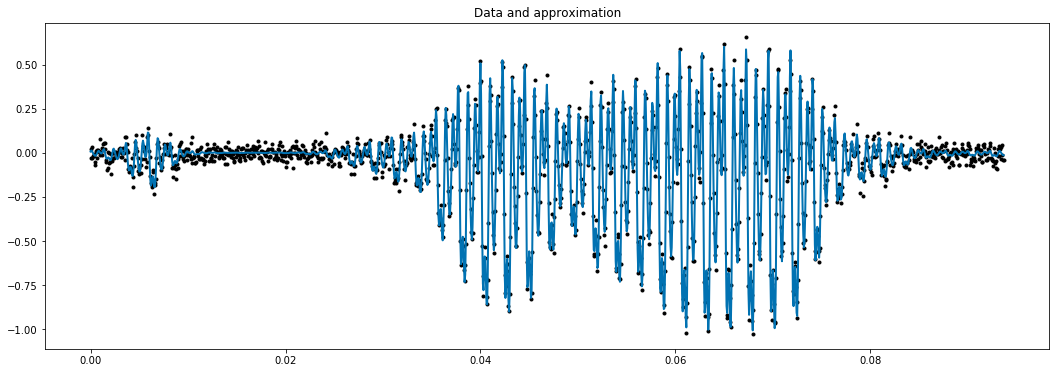

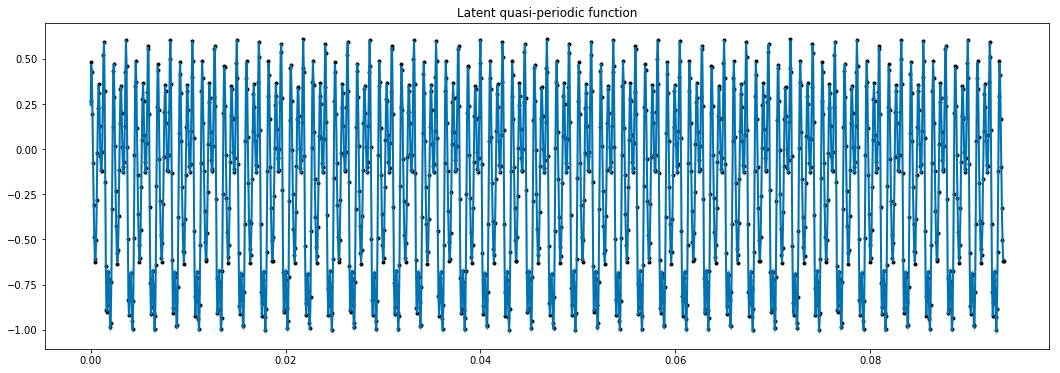

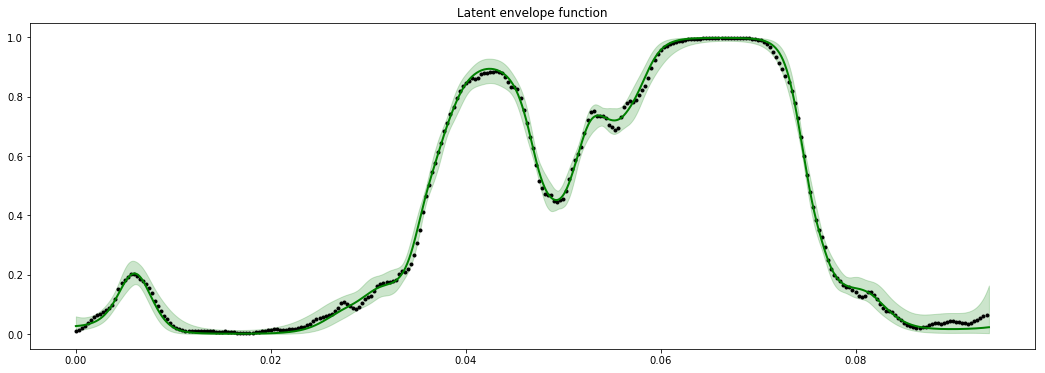

In [8]:
col = '#0172B2'
plt.figure(), plt.title('Data and approximation')
plt.plot(x, y, '.k', mew=1)
plt.plot(x, gpi.logistic(qm2)*qm1, color=col , lw=2)

plt.figure(), plt.title('Latent quasi-periodic function')
plt.plot(x, f, '.k', mew=1)
plt.plot(x, qm1, color=col, lw=2)
plt.fill_between(x[:, 0], qm1[:, 0] - 2*np.sqrt(qv1[:, 0]),
                 qm1[:, 0] + 2*np.sqrt(qv1[:, 0]),
                 color=col, alpha=0.2)

plt.figure(), plt.title('Latent envelope function')
plt.plot(x[::5], gpi.logistic(g[::5]), '.k', mew=1)
plt.plot(x, gpi.logistic(qm2), 'g', lw=2)
plt.fill_between(x[:, 0], gpi.logistic(qm2[:, 0] - 2*np.sqrt(qv2[:, 0])),
                  gpi.logistic(qm2[:, 0] + 2*np.sqrt(qv2[:, 0])),
                  color='green', alpha=0.2)

# Results using old code version

In [9]:
import modgp_old

In [10]:
z = x_l[0][::jump].copy()
m2 = modgp_old.ModGP(x_l[0].copy(), y_l[0].copy(), kper, kenv, z)
m2.likelihood.noise_var = noise_var
m2.likelihood.noise_var.fixed = True
m2.kern1.fixed = True
m2.kern2.fixed = True

qm1 = [np.zeros(z.shape) for i in range(0, Nw)]  # list to save predictions
qm2 = [np.zeros(z.shape) for i in range(0, Nw)]  # mean (qm) and variance (qv)
qv1 = [np.zeros(z.shape) for i in range(0, Nw)]
qv2 = [np.zeros(z.shape) for i in range(0, Nw)]

Ne = 5 # number ox executions
et_oc = np.zeros((Ne, 1))  # execution time old code
mse_oc = np.zeros((Ne, 1))  # meaned squared error old code

In [11]:
for j in range(Ne):
    qm1 = [np.zeros(z.shape) for i in range(0, Nw)]  # list to save predictions
    qm2 = [np.zeros(z.shape) for i in range(0, Nw)]  # mean (qm) and variance (qv)
    qv1 = [np.zeros(z.shape) for i in range(0, Nw)]
    qv2 = [np.zeros(z.shape) for i in range(0, Nw)]
    start_time = time.time()
    for i in range(Nw):
        m2.X = x_l[i].copy()
        m2.Y = y_l[i].copy()
        m2.Z = x_l[i][::jump].copy()
        m2.q_mu1._array = np.zeros(z.shape)
        m2.q_mu2._array = np.zeros(z.shape)
        m2.q_sqrt1._array = np.expand_dims(np.eye(z.size), 2)
        m2.q_sqrt2._array = np.expand_dims(np.eye(z.size), 2)
        m2.kern1.fixed = True
        m2.kern2.fixed = True
        m2.optimize(disp=1, maxiter=maxiter)
        qm1[i], qv1[i] = m2.predict_f(x_l[i])
        qm2[i], qv2[i] = m2.predict_g(x_l[i])
    et_oc[j] = time.time() - start_time
    print("--- %s seconds ---" % (et_oc[j]))
    qm1 = np.asarray(qm1).reshape(-1, 1)
    qm2 = np.asarray(qm2).reshape(-1, 1)
    qv1 = np.asarray(qv1).reshape(-1, 1)
    qv2 = np.asarray(qv2).reshape(-1, 1)
    mse_oc[j] = mse(mean, gpi.logistic(qm2)*qm1)
    print("--- %s mse ---" % (mse_oc[j]))

--- [ 63.6067059] seconds ---
--- [ 0.03465257] mse ---
--- [ 66.877738] seconds ---
--- [ 0.03465257] mse ---
--- [ 64.83053303] seconds ---
--- [ 0.03465257] mse ---
--- [ 66.30952907] seconds ---
--- [ 0.03465257] mse ---
--- [ 63.05399394] seconds ---
--- [ 0.03465257] mse ---


In [12]:
print 'time \n', et_oc
print 'error \n', mse_oc

time 
[[ 63.6067059 ]
 [ 66.877738  ]
 [ 64.83053303]
 [ 66.30952907]
 [ 63.05399394]]
error 
[[ 0.03465257]
 [ 0.03465257]
 [ 0.03465257]
 [ 0.03465257]
 [ 0.03465257]]


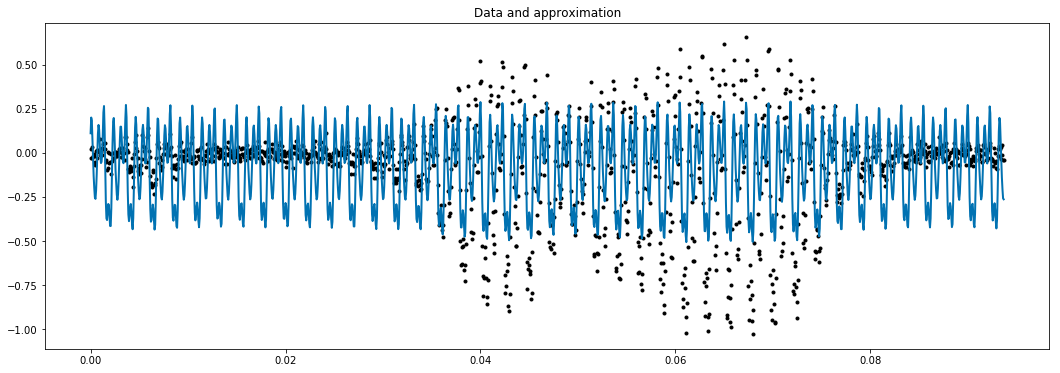

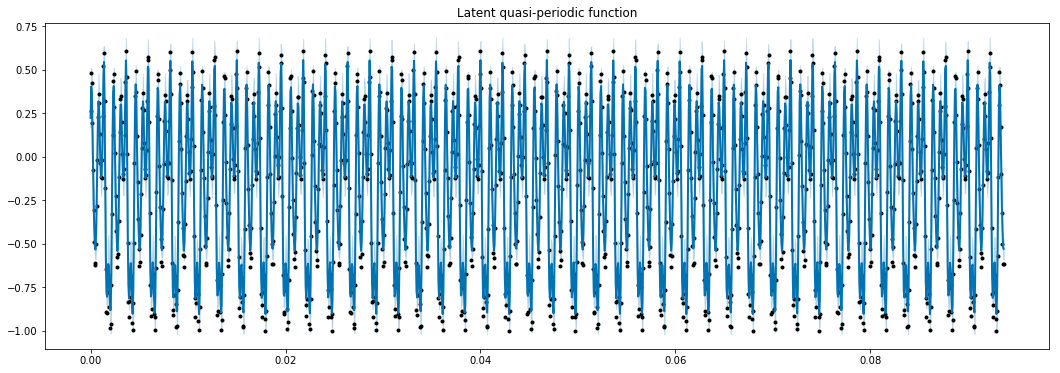

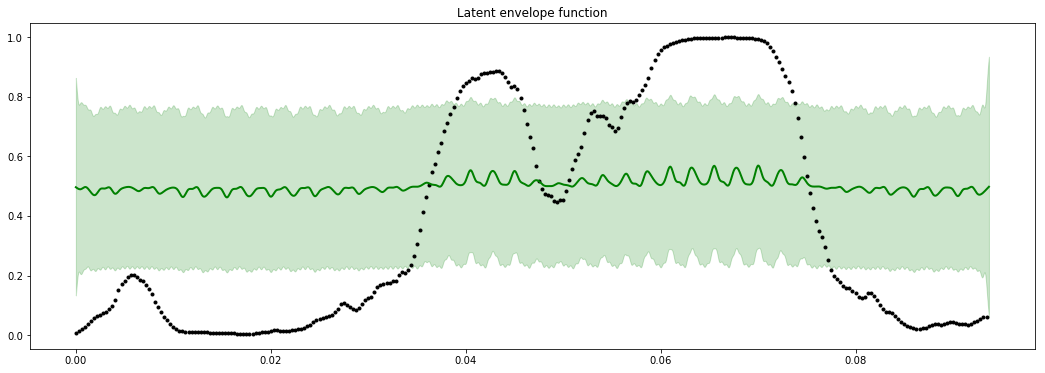

In [13]:
col = '#0172B2'
plt.figure(), plt.title('Data and approximation')
plt.plot(x, y, '.k', mew=1)
plt.plot(x, gpi.logistic(qm2)*qm1, color=col , lw=2)

plt.figure(), plt.title('Latent quasi-periodic function')
plt.plot(x, f, '.k', mew=1)
plt.plot(x, qm1, color=col, lw=2)
plt.fill_between(x[:, 0], qm1[:, 0] - 2*np.sqrt(qv1[:, 0]),
                 qm1[:, 0] + 2*np.sqrt(qv1[:, 0]),
                 color=col, alpha=0.2)

plt.figure(), plt.title('Latent envelope function')
plt.plot(x[::5], gpi.logistic(g[::5]), '.k', mew=1)
plt.plot(x, gpi.logistic(qm2), 'g', lw=2)
plt.fill_between(x[:, 0], gpi.logistic(qm2[:, 0] - 2*np.sqrt(qv2[:, 0])),
                  gpi.logistic(qm2[:, 0] + 2*np.sqrt(qv2[:, 0])),
                  color='green', alpha=0.2)

# Boxplots: execution time and MSE 

([<matplotlib.axis.XTick at 0x7f9e59344f10>,
 <a list of 2 Text xticklabel objects>)

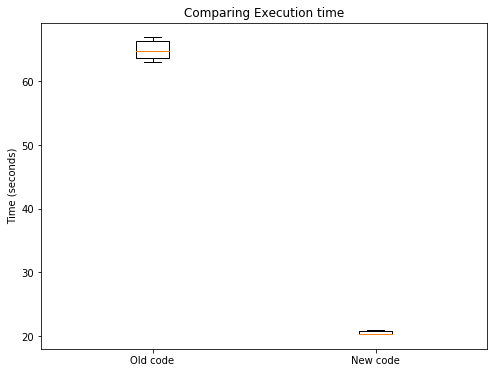

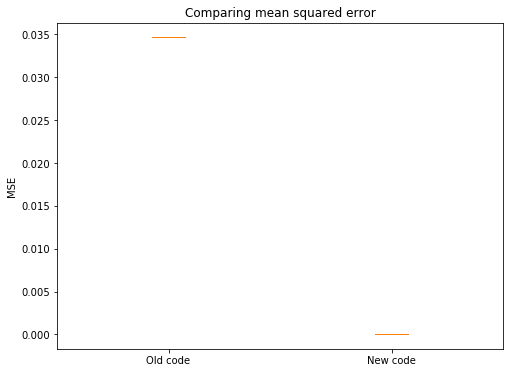

In [14]:
plt.rcParams['figure.figsize'] = (8, 6)  # set plot size
plt.figure()
plt.boxplot([et_oc, et_nc], 0, ''), plt.title('Comparing Execution time')
plt.ylabel('Time (seconds)')
plt.xticks([1, 2], ['Old code', 'New code'])

plt.figure(), plt.title('Comparing mean squared error')
plt.boxplot([mse_oc, mse_nc], 0, '')
plt.ylabel('MSE')
plt.xticks([1, 2], ['Old code', 'New code'])